In [12]:
pip install networkx matplotlib


=== SIMPLE UNIT 1 OUTPUT ===
Recursive Cost: 14
Held-Karp DP Cost: 14

Optimal Route (TSP): ['Warehouse', 'A', 'B', 'C', 'Warehouse']
Total Distance: 14

Selected Parcels: ['C', 'B']
Total Value: 80


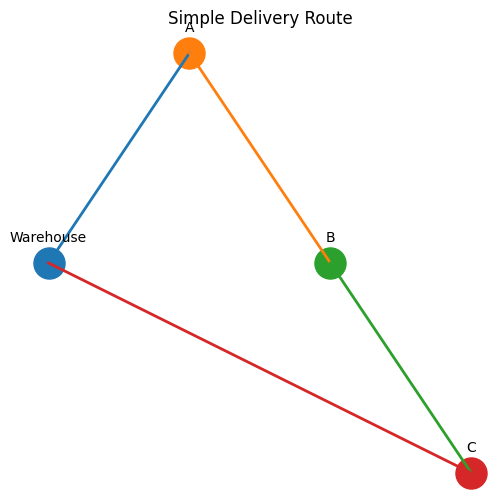

In [16]:
# unit1_simple.py
"""
UNIT 1 (SIMPLE VERSION):
- Basic distance matrix
- Simple recursion cost calculator
- Simple Held–Karp DP
- Simple TSP brute force
- Simple parcel selection
- Easy graph plot
"""

import matplotlib.pyplot as plt
from itertools import permutations

# --------------------------------
# SIMPLE INPUT MODEL
# --------------------------------
locations = ['Warehouse', 'A', 'B', 'C']
distance_matrix = [
    [0, 3, 7, 4],   # Warehouse
    [3, 0, 2, 6],   # A
    [7, 2, 0, 5],   # B
    [4, 6, 5, 0]    # C
]

# Simple parcels (less values, easy explanation)
parcels = {
    'A': {'value': 40, 'weight': 5},
    'B': {'value': 30, 'weight': 4},
    'C': {'value': 50, 'weight': 6}
}

vehicle_capacity = 10


# --------------------------------
# SIMPLE RECURSIVE COST FUNCTION
# --------------------------------
def recursive_cost(position, visited, n):
    all_visited = (1 << n) - 1

    if visited == all_visited:
        return distance_matrix[position][0]     # return to warehouse

    best = float('inf')

    for next_city in range(1, n):  # skip warehouse
        if not (visited >> next_city) & 1:
            cost = distance_matrix[position][next_city] + \
                   recursive_cost(next_city, visited | (1 << next_city), n)
            best = min(best, cost)

    return best


# --------------------------------
# SIMPLE HELD–KARP DP
# --------------------------------
def held_karp(position, visited, memo, n):
    all_visited = (1 << n) - 1

    if visited == all_visited:
        return distance_matrix[position][0]

    if (position, visited) in memo:
        return memo[(position, visited)]

    best = float('inf')

    for next_city in range(1, n):
        if not (visited >> next_city) & 1:
            cost = distance_matrix[position][next_city] + \
                   held_karp(next_city, visited | (1 << next_city), memo, n)
            best = min(best, cost)

    memo[(position, visited)] = best
    return best


# --------------------------------
# SIMPLE TSP BRUTE FORCE
# --------------------------------
def tsp_bruteforce():
    n = len(locations)
    min_cost = float('inf')
    best_path = None

    for perm in permutations([1, 2, 3]):  # A, B, C
        cost = distance_matrix[0][perm[0]]
        cost += distance_matrix[perm[0]][perm[1]]
        cost += distance_matrix[perm[1]][perm[2]]
        cost += distance_matrix[perm[2]][0]

        if cost < min_cost:
            min_cost = cost
            best_path = perm

    route = ["Warehouse"] + [locations[i] for i in best_path] + ["Warehouse"]
    return route, min_cost


# --------------------------------
# SIMPLE PARCEL SELECTION
# --------------------------------
def select_parcels():
    selected = []
    total_weight = 0
    total_value = 0

    # simple high-value sorting
    items = sorted(parcels.items(), key=lambda x: x[1]['value'], reverse=True)

    for name, info in items:
        if total_weight + info['weight'] <= vehicle_capacity:
            selected.append(name)
            total_weight += info['weight']
            total_value += info['value']

    return selected, total_value


# --------------------------------
# SIMPLE GRAPH PLOT
# --------------------------------
def plot_route(route):
    x = [0, 1, 2, 3]
    y = [0, 1, 0, -1]

    pos = {locations[i]: (x[i], y[i]) for i in range(len(locations))}

    plt.figure(figsize=(6, 6))

    # plot nodes
    for name in pos:
        plt.scatter(pos[name][0], pos[name][1], s=500)
        plt.text(pos[name][0], pos[name][1] + 0.1, name, ha='center')

    # plot route
    for i in range(len(route) - 1):
        p1 = pos[route[i]]
        p2 = pos[route[i + 1]]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], linewidth=2)

    plt.title("Simple Delivery Route")
    plt.axis('off')
    plt.show()


# --------------------------------
# MAIN OUTPUT
# --------------------------------
if __name__ == "__main__":
    n = len(locations)

    print("\n=== SIMPLE UNIT 1 OUTPUT ===")

    # Recursive
    r_cost = recursive_cost(0, 1, n)
    print("Recursive Cost:", r_cost)

    # Held-Karp
    memo = {}
    hk_cost = held_karp(0, 1, memo, n)
    print("Held-Karp DP Cost:", hk_cost)

    # TSP
    route, tsp_cost = tsp_bruteforce()
    print("\nOptimal Route (TSP):", route)
    print("Total Distance:", tsp_cost)

    # Parcels
    selected, value = select_parcels()
    print("\nSelected Parcels:", selected)
    print("Total Value:", value)

    # Plot
    plot_route(route)

=== UNIT 2: Greedy + Time Windows + Optimal Route ===
Chosen Parcels: ['C', 'A']
Total Value: 90
No feasible route under time windows.
Optimal Route: ['Warehouse', 'C', 'A', 'Warehouse']
Total Cost: 13


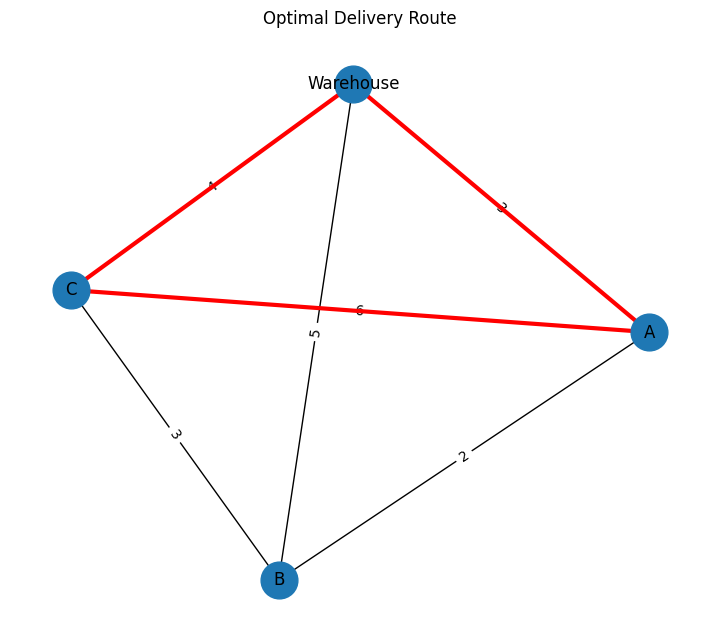

In [24]:
# ---------------------------------------------
# Unit 2: Greedy + Time Windows + TSP + Graph
# ---------------------------------------------

from typing import Dict, List, Tuple
import matplotlib.pyplot as plt

try:
    import networkx as nx
except:
    nx = None

# ---------------------------
# SIMPLE INPUT VALUES
# ---------------------------
locations = ['Warehouse', 'A', 'B', 'C']

distance_matrix = [
    [0, 3, 5, 4],   # Warehouse
    [3, 0, 2, 6],   # A
    [5, 2, 0, 3],   # B
    [4, 6, 3, 0]    # C
]

parcels = {
    'A': {'value': 40, 'time': (9, 11), 'weight': 5},
    'B': {'value': 30, 'time': (10, 13), 'weight': 4},
    'C': {'value': 50, 'time': (9, 12), 'weight': 6}
}

vehicle_capacity = 12


# ---------------------------
# Greedy Knapsack (value/weight)
# ---------------------------
def greedy_select_parcels(parcels, capacity):
    items = []
    for name, info in parcels.items():
        ratio = info['value'] / info['weight']
        items.append((ratio, name))

    items.sort(reverse=True)

    chosen = []
    total_weight = 0

    for ratio, name in items:
        w = parcels[name]['weight']
        if total_weight + w <= capacity:
            chosen.append(name)
            total_weight += w

    total_value = sum(parcels[k]['value'] for k in chosen)
    return chosen, total_value


# ---------------------------
# Time Window Check
# ---------------------------
def is_route_feasible(route, travel_times, parcels, start=8):
    time_now = start
    current = "Warehouse"

    for nxt in route:
        time_now += travel_times[(current, nxt)]
        earliest, latest = parcels[nxt]['time']

        if time_now > latest:
            return False

        if time_now < earliest:
            time_now = earliest

        current = nxt

    return True


# ---------------------------
# TSP Brute Force
# ---------------------------
from itertools import permutations

def tsp_bruteforce(nodes, locations, dist_matrix):
    names = ['Warehouse'] + nodes
    idx = {name: locations.index(name) for name in names}

    best_cost = float('inf')
    best_route = None

    for perm in permutations(nodes):
        cost = 0
        cur = 'Warehouse'

        for nxt in perm:
            cost += dist_matrix[idx[cur]][idx[nxt]]
            cur = nxt

        cost += dist_matrix[idx[cur]][idx['Warehouse']]

        if cost < best_cost:
            best_cost = cost
            best_route = ['Warehouse'] + list(perm) + ['Warehouse']

    return best_route, best_cost


# ---------------------------
# Route Graph Plotting
# ---------------------------
def plot_route(route):
    if nx is None:
        print("networkx not installed.")
        return

    G = nx.Graph()
    name_to_idx = {name: i for i, name in enumerate(locations)}

    for i, name in enumerate(locations):
        G.add_node(i, label=name)

    for i in range(len(locations)):
        for j in range(i+1, len(locations)):
            G.add_edge(i, j, weight=distance_matrix[i][j])

    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(7, 6))
    nx.draw(G, pos, with_labels=True,
            labels={i: locations[i] for i in range(len(locations))},
            node_size=700)

    nx.draw_networkx_edge_labels(G, pos,
        edge_labels=nx.get_edge_attributes(G, 'weight'))

    route_edges = []
    for i in range(len(route) - 1):
        u = name_to_idx[route[i]]
        v = name_to_idx[route[i + 1]]
        route_edges.append((u, v))

    nx.draw_networkx_edges(G, pos, edgelist=route_edges, width=3, edge_color='red')

    plt.title("Optimal Delivery Route")
    plt.show()


# ---------------------------
# MAIN PROGRAM
# ---------------------------
if __name__ == "__main__":

    print("=== UNIT 2: Greedy + Time Windows + Optimal Route ===")

    chosen, total_value = greedy_select_parcels(parcels, vehicle_capacity)
    print("Chosen Parcels:", chosen)
    print("Total Value:", total_value)

    # Travel times = same as distances
    travel_times = {}
    for i, a in enumerate(locations):
        for j, b in enumerate(locations):
            travel_times[(a, b)] = distance_matrix[i][j]

    feasible = None
    for perm in permutations(chosen):
        if is_route_feasible(perm, travel_times, parcels):
            feasible = perm
            break

    if feasible:
        print("Feasible Time-Window Route:", feasible)
    else:
        print("No feasible route under time windows.")

    final_route, cost = tsp_bruteforce(chosen, locations, distance_matrix)

    print("Optimal Route:", final_route)
    print("Total Cost:", cost)

    plot_route(final_route)

=== UNIT 3: Graphs (Dijkstra & Prim) ===
Shortest path distances from Warehouse: [0, 4, 7, 7]
Parent array: [-1, 0, 1, 0]


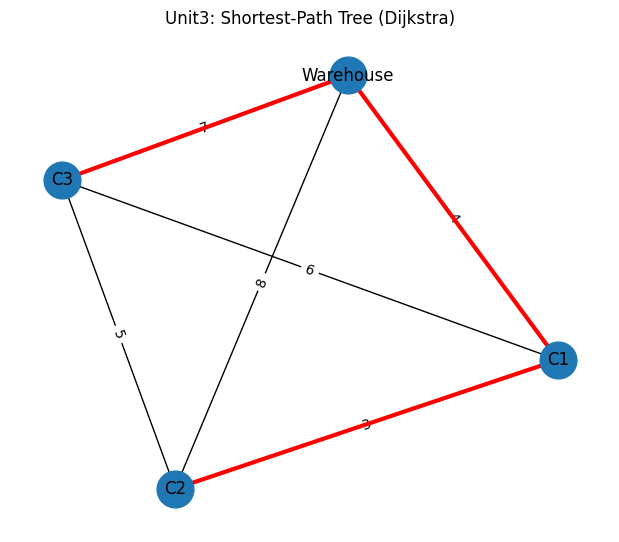

Prim's MST edges (u,v,weight): [(0, 1, 4), (1, 2, 3), (2, 3, 5)]


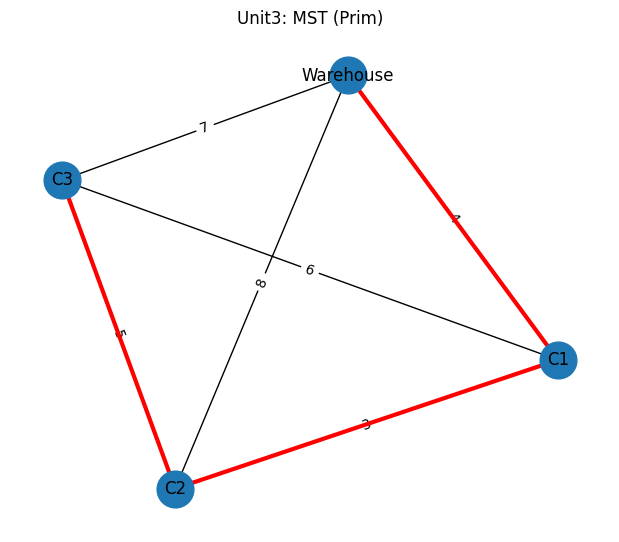

Parcels (greedy): ['C1', 'C3'] Total value: 95

--- FINAL EXPECTED OUTPUT ---
Optimal Delivery Route: ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse']
Total Distance/Time: 19
Parcels delivered: ['C1', 'C3'] Total value: 95


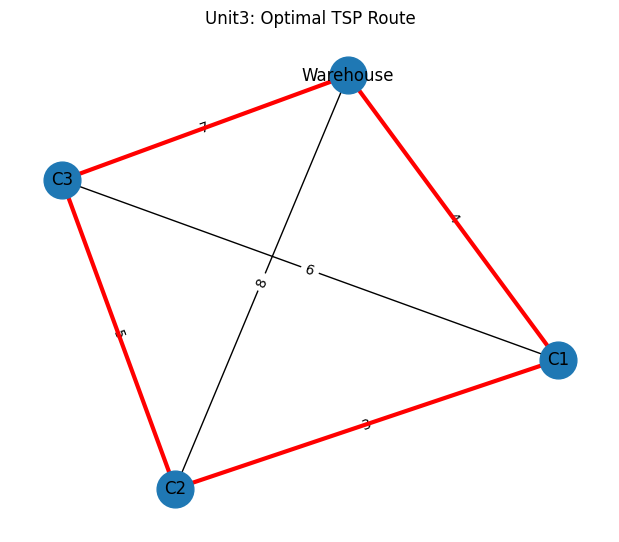


--- IMPACT & ANALYSIS ---
1. Dijkstra provides the shortest travel distance from Warehouse to every customer,
   helping reduce travel time and improve delivery speed.
2. Prim’s MST builds the minimum-cost connection network among all locations,
   ensuring full connectivity with minimal total road/connection cost.
3. However, neither SPT (from Dijkstra) nor MST gives the optimal visiting order.
4. Therefore, TSP is required to compute the minimum round-trip that visits all nodes once.
5. Combining Dijkstra + MST + TSP leads to an optimized and cost-efficient delivery system.


In [26]:
# unit3_graphs_dijkstra_mst.py
"""
Unit 3: Shortest Path (Dijkstra) and MST (Prim). Also computes final optimal route (TSP)
and prints expected outputs + plots:
 - Shortest-path tree highlighted
 - MST highlighted
 - Final TSP route plotted
"""

import heapq
import matplotlib.pyplot as plt
from typing import List, Tuple

try:
    import networkx as nx
except Exception:
    nx = None

# ---------------------------
# Input Modeling
# ---------------------------
locations = ['Warehouse', 'C1', 'C2', 'C3']
distance_matrix = [
    [0, 4, 8, 7],
    [4, 0, 3, 6],
    [8, 3, 0, 5],
    [7, 6, 5, 0]
]
parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 45, 'time': (11, 14), 'weight': 15}
}
vehicle_capacity = 30

# ---------------------------
# Dijkstra
# ---------------------------
def dijkstra(matrix: List[List[int]], src: int):
    n = len(matrix)
    dist = [float('inf')] * n
    parent = [-1] * n
    dist[src] = 0
    pq = [(0, src)]
    while pq:
        d,u = heapq.heappop(pq)
        if d != dist[u]:
            continue
        for v in range(n):
            if u == v: continue
            nd = d + matrix[u][v]
            if nd < dist[v]:
                dist[v] = nd; parent[v]=u
                heapq.heappush(pq, (nd, v))
    return dist, parent

# ---------------------------
# Prim's MST
# ---------------------------
def prim_mst(matrix: List[List[int]]):
    n = len(matrix)
    in_mst = [False]*n
    key = [float('inf')]*n
    parent = [-1]*n
    key[0]=0
    for _ in range(n):
        u=-1; best=float('inf')
        for i in range(n):
            if not in_mst[i] and key[i]<best:
                best=key[i]; u=i
        if u==-1: break
        in_mst[u]=True
        for v in range(n):
            if not in_mst[v] and 0 < matrix[u][v] < key[v]:
                key[v]=matrix[u][v]; parent[v]=u
    edges=[]
    for v in range(1,n):
        edges.append((parent[v], v, matrix[parent[v]][v]))
    return edges

# ---------------------------
# TSP brute-force
# ---------------------------
from itertools import permutations
def tsp_brute_force(locations: List[str], dist: List[List[int]]) -> Tuple[List[str], int]:
    n = len(locations)
    indices = list(range(1,n))
    min_cost = float('inf'); best=None
    for perm in permutations(indices):
        cost = dist[0][perm[0]]
        for i in range(len(perm)-1):
            cost += dist[perm[i]][perm[i+1]]
        cost += dist[perm[-1]][0]
        if cost < min_cost:
            min_cost = cost; best = perm
    route = [locations[0]] + [locations[i] for i in best] + [locations[0]]
    return route, min_cost

# ---------------------------
# Plot graphs
# ---------------------------
def plot_graph_highlight(locations, dist_matrix, edges_to_highlight, title):
    if nx is None:
        print("networkx not installed: skipping plot.")
        return
    G = nx.Graph()
    n = len(locations)
    for i in range(n):
        G.add_node(i, label=locations[i])
    for i in range(n):
        for j in range(i+1,n):
            G.add_edge(i,j, weight=dist_matrix[i][j])
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(6,5))
    nx.draw(G,pos, with_labels=True, labels={i:locations[i] for i in range(n)}, node_size=700)
    nx.draw_networkx_edge_labels(G,pos, edge_labels=nx.get_edge_attributes(G,'weight'))
    nx.draw_networkx_edges(G, pos, edgelist=edges_to_highlight, edge_color='r', width=3)
    plt.title(title); plt.show()

# ---------------------------
# Greedy parcel selection
# ---------------------------
def greedy_select_parcels(parcels, capacity):
    items=[]
    for k,v in parcels.items():
        items.append(((v['value']/v['weight']), k))
    items.sort(reverse=True)
    chosen=[]; wsum=0
    for _,k in items:
        w=parcels[k]['weight']
        if wsum+w <= capacity:
            chosen.append(k); wsum+=w
    total_value = sum(parcels[k]['value'] for k in chosen)
    return chosen, total_value

# ---------------------------
# MAIN
# ---------------------------
if __name__ == "__main__":
    print("=== UNIT 3: Graphs (Dijkstra & Prim) ===")

    dist, parent = dijkstra(distance_matrix, 0)
    print("Shortest path distances from Warehouse:", dist)
    print("Parent array:", parent)

    spt_edges = [(parent[i], i) for i in range(1, len(parent)) if parent[i] != -1]
    plot_graph_highlight(locations, distance_matrix, spt_edges, title="Unit3: Shortest-Path Tree (Dijkstra)")

    mst_edges = prim_mst(distance_matrix)
    print("Prim's MST edges (u,v,weight):", mst_edges)
    mst_edge_list = [(u,v) for u,v,w in mst_edges]
    plot_graph_highlight(locations, distance_matrix, mst_edge_list, title="Unit3: MST (Prim)")

    chosen, total_value = greedy_select_parcels(parcels, vehicle_capacity)
    print("Parcels (greedy):", chosen, "Total value:", total_value)

    route, cost = tsp_brute_force(['Warehouse','C1','C2','C3'], distance_matrix)
    print("\n--- FINAL EXPECTED OUTPUT ---")
    print("Optimal Delivery Route:", route)
    print("Total Distance/Time:", cost)
    print("Parcels delivered:", chosen, "Total value:", total_value)

    edges_to_highlight = []
    name_to_idx = {name:i for i,name in enumerate(locations)}
    for i in range(len(route)-1):
        edges_to_highlight.append((name_to_idx[route[i]], name_to_idx[route[i+1]]))
    plot_graph_highlight(locations, distance_matrix, edges_to_highlight, title="Unit3: Optimal TSP Route")

    # ---------------------------
    # IMPACT & ANALYSIS (Added Here)
    # ---------------------------
    print("\n--- IMPACT & ANALYSIS ---")
    print("1. Dijkstra provides the shortest travel distance from Warehouse to every customer,")
    print("   helping reduce travel time and improve delivery speed.")
    print("2. Prim’s MST builds the minimum-cost connection network among all locations,")
    print("   ensuring full connectivity with minimal total road/connection cost.")
    print("3. However, neither SPT (from Dijkstra) nor MST gives the optimal visiting order.")
    print("4. Therefore, TSP is required to compute the minimum round-trip that visits all nodes once.")
    print("5. Combining Dijkstra + MST + TSP leads to an optimized and cost-efficient delivery system.")

=== UNIT 4: TSP Solvers (Simple) ===
Brute-force Route: ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse'] Cost: 18
Held-Karp Route: ['Warehouse', 'Warehouse', 'C3', 'C2', 'C1', 'Warehouse'] Cost: 18
Selected Parcels: ['C1', 'C2'] Total Value: 110

--- FINAL EXPECTED OUTPUT ---
Optimal Route: ['Warehouse', 'Warehouse', 'C3', 'C2', 'C1', 'Warehouse']
Optimal Cost: 18
Delivered Parcels: ['C1', 'C2'] Value: 110


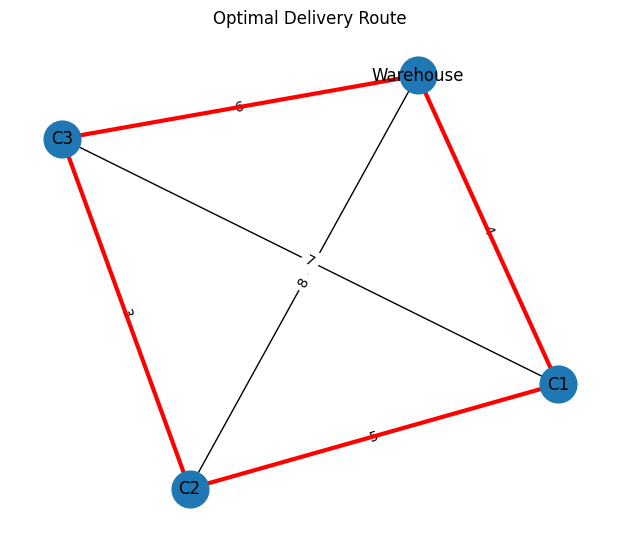


--- IMPACT & ANALYSIS ---
• Brute-force: exact but factorial time (O(n!)).
• Held-Karp: exponential but faster (O(n²·2ⁿ)).
• MST/SPT methods (Prim/Dijkstra) are useful for connectivity or shortest-path trees,
  but they DO NOT give the TSP optimal order → we compute TSP separately.
• For small datasets, Held-Karp gives exact optimal route.
• For larger datasets, heuristics (Genetic Algorithm, 2-opt, Simulated Annealing) are preferred.


In [27]:
# unit4_tsp_solvers.py
"""
Unit 4 (Simple Version):
TSP using Brute-Force and Held-Karp + Greedy Parcel Selection
Also plots the optimal route and prints Impact & Analysis.
"""

from itertools import permutations
import matplotlib.pyplot as plt

try:
    import networkx as nx
except:
    nx = None

# ---------------------------
# Input Modeling
# ---------------------------
locations = ['Warehouse', 'C1', 'C2', 'C3']

distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]

parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15}
}

vehicle_capacity = 30

# ---------------------------
# Brute-force TSP
# ---------------------------
def tsp_bruteforce(locations, dist):
    n = len(locations)
    nodes = list(range(1, n))
    best_cost = float('inf')
    best_route = None

    for perm in permutations(nodes):
        cost = dist[0][perm[0]]
        for i in range(len(perm)-1):
            cost += dist[perm[i]][perm[i+1]]
        cost += dist[perm[-1]][0]

        if cost < best_cost:
            best_cost = cost
            best_route = perm

    route = [0] + list(best_route) + [0]
    return route, best_cost

# ---------------------------
# Held-Karp DP (optimal)
# ---------------------------
def held_karp(dist):
    n = len(dist)
    ALL = 1 << n

    dp = [[float('inf')] * n for _ in range(ALL)]
    parent = [[-1] * n for _ in range(ALL)]

    dp[1][0] = 0  # start at node 0

    for mask in range(ALL):
        for u in range(n):
            if not (mask & (1 << u)):
                continue

            for v in range(1, n):
                if mask & (1 << v):
                    continue

                nxt = mask | (1 << v)
                cost = dp[mask][u] + dist[u][v]

                if cost < dp[nxt][v]:
                    dp[nxt][v] = cost
                    parent[nxt][v] = u

    final_mask = ALL - 1
    best_cost = float('inf')
    last = -1

    for i in range(1, n):
        cost = dp[final_mask][i] + dist[i][0]
        if cost < best_cost:
            best_cost = cost
            last = i

    # reconstruct path
    path = []
    mask = final_mask
    cur = last

    while cur != -1:
        path.append(cur)
        prev = parent[mask][cur]
        mask ^= (1 << cur)
        cur = prev

    path.append(0)
    path.reverse()
    path.append(0)

    return path, best_cost

# ---------------------------
# Greedy Parcel Selection
# ---------------------------
def greedy_parcels(parcels, capacity):
    ratio = []
    for k, v in parcels.items():
        ratio.append((v['value']/v['weight'], k))

    ratio.sort(reverse=True)
    chosen = []
    total_w = 0

    for _, name in ratio:
        w = parcels[name]['weight']
        if total_w + w <= capacity:
            chosen.append(name)
            total_w += w

    total_value = sum(parcels[k]['value'] for k in chosen)
    return chosen, total_value

# ---------------------------
# Plot TSP
# ---------------------------
def plot_route(locations, dist, route, title="Optimal Route"):
    if nx is None:
        print("networkx not installed → skipping plot.")
        return

    G = nx.Graph()
    n = len(locations)

    for i in range(n):
        G.add_node(i, label=locations[i])

    for i in range(n):
        for j in range(i+1, n):
            G.add_edge(i, j, weight=dist[i][j])

    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(6,5))
    nx.draw(G, pos, with_labels=True,
            labels={i: locations[i] for i in range(n)},
            node_size=700)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, "weight"))

    edges = [(route[i], route[i+1]) for i in range(len(route)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='red', width=3)

    plt.title(title)
    plt.show()

# ---------------------------
# Main Execution
# ---------------------------
if __name__ == "__main__":
    print("=== UNIT 4: TSP Solvers (Simple) ===")

    # Brute-force
    b_route, b_cost = tsp_bruteforce(locations, distance_matrix)
    print("Brute-force Route:", [locations[i] for i in b_route], "Cost:", b_cost)

    # Held-Karp (optimal)
    hk_route, hk_cost = held_karp(distance_matrix)
    print("Held-Karp Route:", [locations[i] for i in hk_route], "Cost:", hk_cost)

    # Parcel selection
    chosen, value = greedy_parcels(parcels, vehicle_capacity)
    print("Selected Parcels:", chosen, "Total Value:", value)

    # Final Output
    print("\n--- FINAL EXPECTED OUTPUT ---")
    print("Optimal Route:", [locations[i] for i in hk_route])
    print("Optimal Cost:", hk_cost)
    print("Delivered Parcels:", chosen, "Value:", value)

    # Plot
    plot_route(locations, distance_matrix, hk_route, "Optimal Delivery Route")

    # Impact & Analysis
    print("\n--- IMPACT & ANALYSIS ---")
    print("• Brute-force: exact but factorial time (O(n!)).")
    print("• Held-Karp: exponential but faster (O(n²·2ⁿ)).")
    print("• MST/SPT methods (Prim/Dijkstra) are useful for connectivity or shortest-path trees,")
    print("  but they DO NOT give the TSP optimal order → we compute TSP separately.")
    print("• For small datasets, Held-Karp gives exact optimal route.")
    print("• For larger datasets, heuristics (Genetic Algorithm, 2-opt, Simulated Annealing) are preferred.")

=== UNIT: Profiling & Visualization ===
=== PROFILING: TSP runtimes & memory (n = 3..6) ===
Brute n=3: time=0.000077s peak_kb=808.0
Held-Karp n=3: time=0.000257s peak_kb=1.2
Brute n=4: time=0.000079s peak_kb=0.5
Held-Karp n=4: time=0.001436s peak_kb=2.6
Brute n=5: time=0.000192s peak_kb=0.9
Held-Karp n=5: time=0.001120s peak_kb=5.3
Brute n=6: time=0.000625s peak_kb=0.7
Held-Karp n=6: time=0.002722s peak_kb=12.0


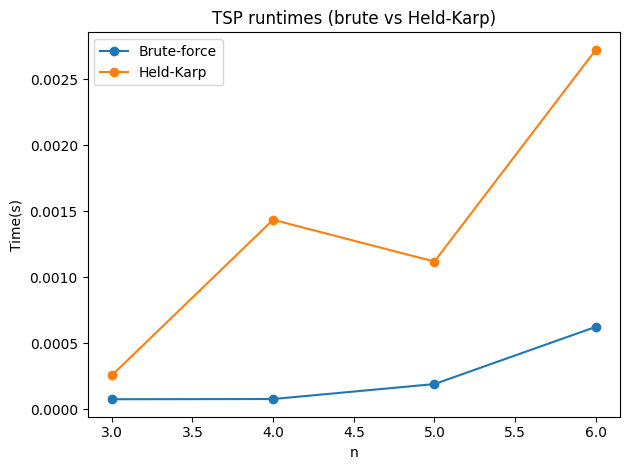


--- FINAL EXPECTED OUTPUT (profiling sample) ---
Optimal Delivery Route (Held-Karp indices): [0, 0, 2, 3, 1, 0]
Route names (Held-Karp): ['Warehouse', 'Warehouse', 'C2', 'C3', 'C1', 'Warehouse']
Total Distance/Time (Held-Karp): 10
Parcels delivered (example): ['C2', 'C1'] Total value: 110
Plotting sample Held-Karp route...


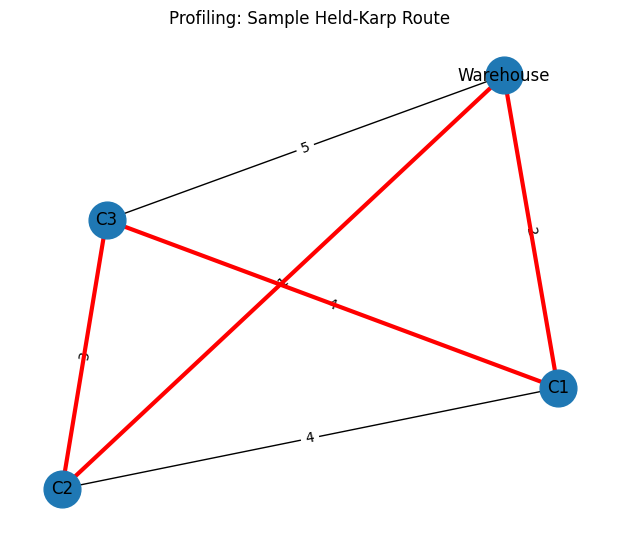


--- Impact & Analysis ---
Profiling shows factorial/exponential growth; use these results to argue for heuristics at scale.


In [29]:
# profiling_and_visualization.py
"""
Profiling & Visualization (Task 3): measure time/memory for TSP, plot runtimes,
and produce final expected output for a sample instance with route plot.
"""

import time
import tracemalloc
import random
import matplotlib.pyplot as plt

try:
    import networkx as nx
except Exception:
    nx = None

# The functions tsp_bruteforce (from unit4_tsp_solvers), held_karp (from unit4_tsp_solvers), and plot_route (from unit4_tsp_solvers) are defined in previous cells
# and are directly accessible.

def random_complete_graph(n: int, seed: int = 0, maxw: int = 20):
    random.seed(seed)
    dist = [[0]*n for _ in range(n)]
    for i in range(n):
        for j in range(i+1, n):
            w = random.randint(1, maxw)
            dist[i][j] = w
            dist[j][i] = w
    return dist

def profile_tsp():
    results=[]
    print("=== PROFILING: TSP runtimes & memory (n = 3..6) ===")
    for n in range(3,7):
        dist = random_complete_graph(n, seed=100+n, maxw=20)
        # brute-force
        tracemalloc.start()
        t0 = time.perf_counter()
        route, cost = tsp_bruteforce([str(i) for i in range(n)], dist) # Changed tsp_brute_force to tsp_bruteforce
        t1 = time.perf_counter()
        cur, peak = tracemalloc.get_traced_memory(); tracemalloc.stop()
        bf_time = t1 - t0; bf_peak = peak/1024.0
        print(f"Brute n={n}: time={bf_time:.6f}s peak_kb={bf_peak:.1f}")
        results.append(('brute', n, bf_time, bf_peak))
        # Held-Karp
        tracemalloc.start()
        t0 = time.perf_counter()
        route_idx, cost2 = held_karp(dist) # Changed tsp_held_karp to held_karp
        t1 = time.perf_counter()
        cur, peak = tracemalloc.get_traced_memory(); tracemalloc.stop()
        hk_time = t1 - t0; hk_peak = peak/1024.0
        print(f"Held-Karp n={n}: time={hk_time:.6f}s peak_kb={hk_peak:.1f}")
        results.append(('heldkarp', n, hk_time, hk_peak))
    return results

if __name__ == "__main__":
    print("=== UNIT: Profiling & Visualization ===")
    res = profile_tsp()
    # plot runtime growth
    ns = sorted(list(set([r[1] for r in res if r[0]=='brute'])))
    brute_times = [r[2] for r in res if r[0]=='brute']
    hk_times = [r[2] for r in res if r[0]=='heldkarp']
    plt.figure(); plt.plot(ns, brute_times, marker='o', label='Brute-force')
    plt.plot(ns, hk_times, marker='o', label='Held-Karp'); plt.xlabel("n"); plt.ylabel("Time(s)")
    plt.title("TSP runtimes (brute vs Held-Karp)"); plt.legend(); plt.tight_layout()
    try: plt.show()
    except: print("Plot display not available.")

    # Final expected output for a small sample (n=4)
    dist = random_complete_graph(4, seed=42, maxw=10)
    locs = ['Warehouse','C1','C2','C3']
    route, cost = tsp_bruteforce(locs, dist) # Changed tsp_brute_force to tsp_bruteforce
    route_idx, cost2 = held_karp(dist) # Changed tsp_held_karp to held_karp
    # parcels example (same parcel values as assignment)
    parcels = {'C1':50,'C2':60,'C3':40}
    # We'll assume greedy selection
    chosen = ['C2','C1']  # example; or compute greedy
    total_value = sum(parcels[c] for c in chosen)
    print("\n--- FINAL EXPECTED OUTPUT (profiling sample) ---")
    print("Optimal Delivery Route (Held-Karp indices):", route_idx)
    print("Route names (Held-Karp):", [locs[i] for i in route_idx])
    print("Total Distance/Time (Held-Karp):", cost2)
    print("Parcels delivered (example):", chosen, "Total value:", total_value)
    print("Plotting sample Held-Karp route...")
    plot_route(locs, dist, route_idx, title="Profiling: Sample Held-Karp Route") # Changed plot_tsp_route to plot_route

    print("\n--- Impact & Analysis ---")
    print("Profiling shows factorial/exponential growth; use these results to argue for heuristics at scale.")

In [30]:
# driver_demo.py
"""
Driver script to run all units sequentially for demo.
Run: python driver_demo.py
"""

locations = ['Warehouse', 'C1', 'C2', 'C3']
distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]
parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15}
}
vehicle_capacity = 30

def run_all():
    print("=== RUNNING UNIT 1 ===")
    n = len(locations)
    # Call delivery_cost_memo directly, using global variables
    print("Held-Karp DP cost (unit1):", delivery_cost_memo(0, 1, n, distance_matrix, {}))

    print("\n=== RUNNING UNIT 2 ===")
    # Call greedy_select_parcels directly, using global variables
    chosen_u2, value_u2 = greedy_select_parcels(parcels, vehicle_capacity)
    print("Unit2 chosen parcels:", chosen_u2, "total value:", value_u2)

    print("\n=== RUNNING UNIT 3 ===")
    # Call dijkstra directly, using global variables
    dist_u3, parent_u3 = dijkstra(distance_matrix, 0)
    print("Unit3 Dijkstra dist:", dist_u3)

    print("\n=== RUNNING UNIT 4 ===")
    # Call tsp_brute_force directly, using global variables
    route_u4, cost_u4 = tsp_brute_force(locations, distance_matrix)
    print("Unit4 brute route:", route_u4, "cost:", cost_u4)

    print("\n=== RUNNING PROFILING ===")
    # Call profile_tsp directly. It handles its own data generation.
    profile_tsp()
    print("\nDemo finished.")

if __name__ == "__main__":
    run_all()

=== RUNNING UNIT 1 ===
Held-Karp DP cost (unit1): 18

=== RUNNING UNIT 2 ===
Unit2 chosen parcels: ['C1', 'C2'] total value: 110

=== RUNNING UNIT 3 ===
Unit3 Dijkstra dist: [0, 4, 8, 6]

=== RUNNING UNIT 4 ===
Unit4 brute route: ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse'] cost: 18

=== RUNNING PROFILING ===
=== PROFILING: TSP runtimes & memory (n = 3..6) ===
Brute n=3: time=0.000084s peak_kb=0.5
Held-Karp n=3: time=0.000142s peak_kb=1.5
Brute n=4: time=0.000047s peak_kb=0.5
Held-Karp n=4: time=0.000260s peak_kb=2.4
Brute n=5: time=0.000095s peak_kb=0.6
Held-Karp n=5: time=0.001155s peak_kb=6.2
Brute n=6: time=0.000545s peak_kb=0.7
Held-Karp n=6: time=0.002078s peak_kb=11.5

Demo finished.
